In [117]:
# %%bash
# source activate tangram-env

In [14]:
import tangram as tg
import scanpy as sc
import os
import squidpy as sq
import pandas as pd
from datetime import date

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from cellpose import models

In [4]:
# Import the StarDist 2D segmentation models.
from stardist.models import StarDist2D
# Import the recommended normalization technique for stardist.
from csbdeep.utils import normalize

2022-08-24 11:12:59.476494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/icb/christina.hillig/miniconda3/envs/tangram-env/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-24 11:12:59.476989: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
import tensorflow as tf 
print(tf.__version__)
# first install tensorflow : pip install tensorflow
# pip install stardist (if tensorflow version is 2)
# pip install csbdeep

2.8.0


In [6]:
import torch
torch.cuda.is_available()

False

# Cell type mapping and Deconvolution with Tangram
- Tutorial: https://github.com/broadinstitute/Tangram/blob/master/tutorial_tangram_with_squidpy.ipynb

- pros:
    - convienient usability
    - works good on high quality images showing even tissue 

- cons:
    - They apply segementation on whole (cropped) image 
    - they dont use the spot information
    - can't differentiate between tissue structures and nuceli, epidermis and dermis, and after artifacts in the image

In [7]:
# Read in data
input_dir = '/lustre/groups/cbm01/workspace/christina.hillig/2021_Carlos_Talavera_Lopez/adata_storage'
input_dir_2022 = '/lustre/groups/cbm01/workspace/christina.hillig/2022_Visium_eyerich/adata_storage/2022-04-08'
ad_sc = sc.read(os.path.join(input_dir, 'QC_Carlos_DD_normed_umap.h5'))
ad_sp = sc.read(os.path.join(input_dir_2022, 'st_QC_normed_BC_project_PsoADLP.h5'))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
# create save dir
output_dir = os.path.join('/lustre/groups/cbm01/workspace/christina.hillig/2022_Visium_eyerich/Tangram/S4', 
                          str(date.today()))
os.makedirs(output_dir, exist_ok=True)

In [9]:
ad_sp.obs['clusters'] = ad_sp.obs['tissue_layer'].copy()
ad_sc.obs['subclass_label'] = ad_sc.obs['full_clustering'].copy()

In [10]:
ad_sc.obs[['Location', 'Site']]

Location        Site
index                                                     
AAACCTGAGCTACCGC-1-SKN8090524       Lower_back  non_lesion
AAACCTGCACCTCGGA-1-SKN8090524       Lower_back  non_lesion
AAACCTGGTCAGAAGC-1-SKN8090524       Lower_back  non_lesion
AAACCTGGTCGAACAG-1-SKN8090524       Lower_back  non_lesion
AAACCTGTCTCCGGTT-1-SKN8090524       Lower_back  non_lesion
...                                        ...         ...
TTTGGTTTCAGGCCCA-1-4820STDY7389014      Breast  non_lesion
TTTGGTTTCGCCTGTT-1-4820STDY7389014      Breast  non_lesion
TTTGTCAAGGAATCGC-1-4820STDY7389014      Breast  non_lesion
TTTGTCAAGGACTGGT-1-4820STDY7389014      Breast  non_lesion
TTTGTCACACTACAGT-1-4820STDY7389014      Breast  non_lesion

[429285 rows x 2 columns]

- Subset spatial data to only one sample `P15509_1004`

In [11]:
ad_sp_s4 = ad_sp[ad_sp.obs['sample'] == 'P15509_1004'].copy()
En_Value = ad_sp_s4.uns['spatial']['P15509_1004']
ad_sp_s4.uns['spatial'].clear() 
ad_sp_s4.uns['spatial']['P15509_1004'] = En_Value

- subset single cell data to psoriasis & eczema samples

In [12]:
ad_sc_pso = ad_sc[(ad_sc.obs['Status'] == 'Psoriasis') | (ad_sc.obs['Status'] == 'Eczema')].copy()

### Group cell types in scRNA-seq [Not at the moment]

In [39]:
# ad_sc_pso.obs['full_clustering_merged'] = ad_sc_pso.obs['full_clustering'].copy()
# ad_sc_pso.obs['full_clustering_merged'] = ad_sc_pso.obs['full_clustering_merged'].astype(str)
# ad_sc_pso.obs['full_clustering_merged'][
#     ad_sc_pso.obs['full_clustering_merged'].str.contains(
#         'DC[0-9]|Inf_mac|LC_[0-9]|Macro|Mast_cell|MigDC|Mono_mac|moDC')] = 'APC'
# ad_sc_pso.obs['full_clustering_merged'][
#     ad_sc_pso.obs['full_clustering_merged'].str.contains('ILC1_3|ILC2|NK')] ='Innate cells'
# ad_sc_pso.obs['full_clustering_merged'][
#     ad_sc_pso.obs['full_clustering_merged'].str.contains('F[0-9]|Melanocyte|KC')] ='Epithelial cells'
# ad_sc_pso.obs['full_clustering_merged'][
#     ad_sc_pso.obs['full_clustering_merged'].str.contains('Tc|TcIL13_IL22|Tc17_Th17|Th|Treg')] ='T cells'
# ad_sc_pso.obs['full_clustering_merged'][
#     ad_sc_pso.obs['full_clustering_merged'].str.contains('LE[0-9]|Pericyte|VE')] ='Endothelial cells'
# ad_sc_pso.obs['full_clustering_merged'][ad_sc_pso.obs['full_clustering_merged'].str.contains('Plasma')] ='B cells'
# ad_sc_pso.obs['full_clustering_merged'][ad_sc_pso.obs['full_clustering_merged'].str.contains('Schwann')] ='Schwann'

In [40]:
# ad_sc_pso.obs['full_clustering_merged'] = ad_sc_pso.obs['full_clustering_merged'].astype('category')

In [41]:
# ad_sc_pso.obs['full_clustering_merged'].cat.categories

Index(['APC', 'Endothelial cells', 'Epithelial cells', 'Innate cells',
       'Schwann', 'T cells'],
      dtype='object')

## Rename `full_clustering_merged` to `subclass_label`

In [16]:
ad_sc_pso.obs['subclass_label'] = ad_sc_pso.obs['full_clustering'].copy()

- Get frequency of cell types on single cell data

In [17]:
df_count_celltypes = ad_sc_pso.obs['full_clustering'].value_counts().rename_axis('unique_values').reset_index(name='counts')
df_count_celltypes.columns = ['Cell types', 'Counts']
df_count_celltypes = df_count_celltypes.sort_values(by='Counts', ascending=False).reset_index(drop=True)
print(df_count_celltypes)
df_count_celltypes['Cell types'] = df_count_celltypes['Cell types'].astype('category')

             Cell types  Counts
0     Differentiated_KC   56656
1                    F2   23449
2                    Th   19609
3                    Tc   14232
4                   VE2   14115
5    Differentiated_KC*   12975
6                    F3   10464
7            Pericyte_1    8687
8                    F1    8479
9                  Treg    7952
10  Undifferentiated_KC    7371
11              Inf_mac    6554
12           Pericyte_2    5058
13                  VE1    5026
14                  DC2    4518
15           Melanocyte    4439
16         Tc_IL13_IL22    3693
17                  VE3    3471
18                 LC_3    3209
19               moDC_1    2704
20                MigDC    2470
21             Mono_mac    2304
22            Tc17_Th17    2200
23     Proliferating_KC    1961
24              Macro_1    1577
25                  LE1    1550
26                  DC1    1484
27              Macro_2    1463
28                  LE2    1296
29                 LC_1    1257
30      

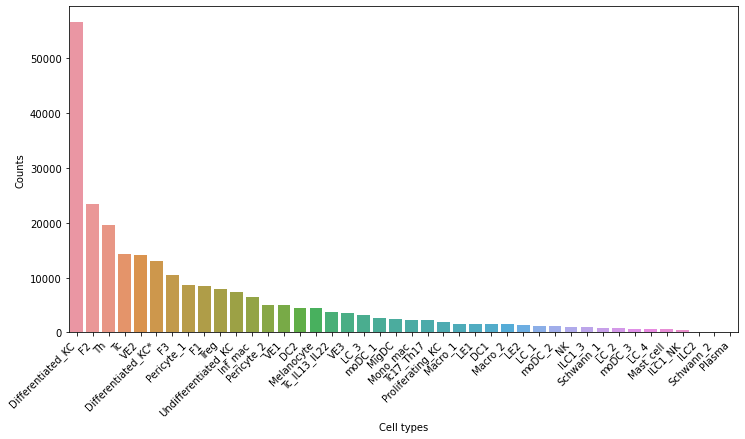

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='Cell types', y='Counts', data=df_count_celltypes, ax=ax, order=df_count_celltypes['Cell types'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.show()

### Remove underrepresented cell types [Not at the moment]

In [17]:
# majority_celltypes = ad_sc_pso.obs[
#     'full_clustering'].value_counts()[ad_sc_pso.obs['full_clustering'].value_counts() > 400]
# ad_sc_pso = ad_sc_pso[ad_sc_pso.obs['full_clustering'].isin(list(majority_celltypes.index))].copy()

## Find common genes between ST and scRNA-seq data

In [19]:
# Find common genes
tg.pp_adatas(ad_sc_pso, ad_sp_s4, genes=None)

INFO:root:14668 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14668 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


# Map cell types
To find the optimal spatial alignment for scRNA-seq profiles, we use the map_cells_to_space function:

- The function maps iteratively as specified by `num_epochs`. We typically interrupt mapping after the score plateaus.
- The score measures the similarity between the gene expression of the mapped cells vs spatial data on the training genes.
- The default mapping mode is `mode='cells'`, which is recommended to run on a GPU. Alternatively, one can specify `mode='clusters'` which averages the single cells beloning to the same cluster (pass annotations via  cluster_label). This is faster, and is our chioce when scRNAseq and spatial data come from different specimens.
- If you wish to run Tangram with a __GPU__, set `device=cuda:0` __otherwise__ use the set `device=cpu`. density_prior specifies the cell density within each spatial voxel. Use uniform if the spatial voxels are at single cell resolution (ie MERFISH). The default value, rna_count_based, assumes that cell density is proportional to the number of RNA molecules.

In [20]:
# Faster mapping
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc_pso, adata_sp=ad_sp_s4,
    num_epochs=500, mode='clusters', cluster_label='subclass_label', 
    density_prior='rna_count_based', device='cpu')

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 14668 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.165
Score: 0.291, KL reg: 0.000
Score: 0.292, KL reg: 0.000
Score: 0.292, KL reg: 0.000
Score: 0.292, KL reg: 0.000


INFO:root:Saving results..


The mapping results are stored in the returned AnnData structure, saved as ad_map, structured as following:
- The cell-by-spot matrix `X` contains the probability of cell `i` to be in spot `j`.
- The `.obs` dataframe contains the metadata of the single cells.
- The `.var` dataframe contains the metadata of the spatial data.
- The `.uns` dictionary contains a dataframe with various information about the training genes (saved ad train_genes_df)

In [21]:
# cell-by-spot matrix X contains the probability of cell i to be in spot j.
print(ad_map.X.shape)
print(ad_map.X.sum(axis=1))
print(ad_map.X[0, :].sum())

(42, 752)
[1.0000001  1.         1.         1.         1.0000001  0.99999994
 1.         0.99999994 1.         0.9999999  1.         1.
 0.99999994 1.         1.0000001  1.         1.         1.
 0.9999999  1.0000001  1.         0.9999999  1.0000001  1.
 1.0000002  1.         1.         1.         1.0000001  1.
 1.         1.0000001  1.         1.0000002  0.99999994 1.0000001
 1.         0.99999994 1.         1.0000001  1.0000004  0.9999999 ]
1.0000001


## Cell type maps
To visualize cell types in space, we invoke `project_cell_annotation` to transfer the annotation from the mapping to space. We can then call `plot_cell_annotation` to visualize it. You can set the perc argument to set the range to the colormap, which would help remove outliers.

In [22]:
tg.project_cell_annotations(ad_map, ad_sp_s4, annotation="subclass_label")
annotation_list = list(pd.unique(ad_sc_pso.obs['subclass_label']))
# tg.plot_cell_annotation_sc(ad_sp, annotation_list, perc=0.02)

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [23]:
# Save mapping
sc.write(os.path.join(output_dir, 'ST_tangram.h5'), ad_sp_s4)
sc.write(os.path.join(output_dir, 'SCST_tangrammapping.h5'), ad_map)

In [25]:
# tg.plot_cell_annotation_sc(ad_sp_s4, annotation_list, perc=0.02)
annotation_list

['Differentiated_KC',
 'Melanocyte',
 'Undifferentiated_KC',
 'LC_4',
 'Differentiated_KC*',
 'LE2',
 'F3',
 'VE1',
 'VE2',
 'Tc',
 'VE3',
 'LC_3',
 'Treg',
 'Mono_mac',
 'Pericyte_1',
 'MigDC',
 'Th',
 'F2',
 'Proliferating_KC',
 'LE1',
 'moDC_1',
 'moDC_2',
 'Macro_1',
 'F1',
 'Pericyte_2',
 'Schwann_1',
 'Schwann_2',
 'Macro_2',
 'moDC_3',
 'Tc_IL13_IL22',
 'LC_1',
 'DC2',
 'DC1',
 'Inf_mac',
 'NK',
 'Mast_cell',
 'ILC1_3',
 'ILC2',
 'LC_2',
 'Plasma',
 'Tc17_Th17',
 'ILC1_NK']

In [26]:
ad_map.obs

subclass_label cluster_density
0     Differentiated_KC        0.228799
1                    F2        0.094696
2                    Th        0.079189
3                    Tc        0.057474
4                   VE2        0.057002
5    Differentiated_KC*        0.052398
6                    F3        0.042258
7            Pericyte_1        0.035081
8                    F1        0.034241
9                  Treg        0.032113
10  Undifferentiated_KC        0.029767
11              Inf_mac        0.026468
12           Pericyte_2        0.020426
13                  VE1        0.020297
14                  DC2        0.018245
15           Melanocyte        0.017926
16         Tc_IL13_IL22        0.014914
17                  VE3        0.014017
18                 LC_3        0.012959
19               moDC_1        0.010920
20                MigDC        0.009975
21             Mono_mac        0.009304
22            Tc17_Th17        0.008884
23     Proliferating_KC        0.007919
24              Macro_1        0.006369
25                  LE1        0.006259
26                  DC1        0.005993
27              Macro_2        0.005908
28                  LE2        0.005234
29                 LC_1        0.005076
30               moDC_2        0.004773
31                   NK        0.004321
32               ILC1_3        0.003998
33            Schwann_1        0.003279
34                 LC_2        0.003001
35               moDC_3        0.002669
36                 LC_4        0.002641
37            Mast_cell        0.002488
38              ILC1_NK        0.001591
39                 ILC2        0.000687
40            Schwann_2        0.000392
41               Plasma        0.000048

- visualize spatial probability maps of the annotation

In [24]:
ad_sp_il17a = ad_sp_s4.copy()
del ad_sp_il17a.uns['spatial']

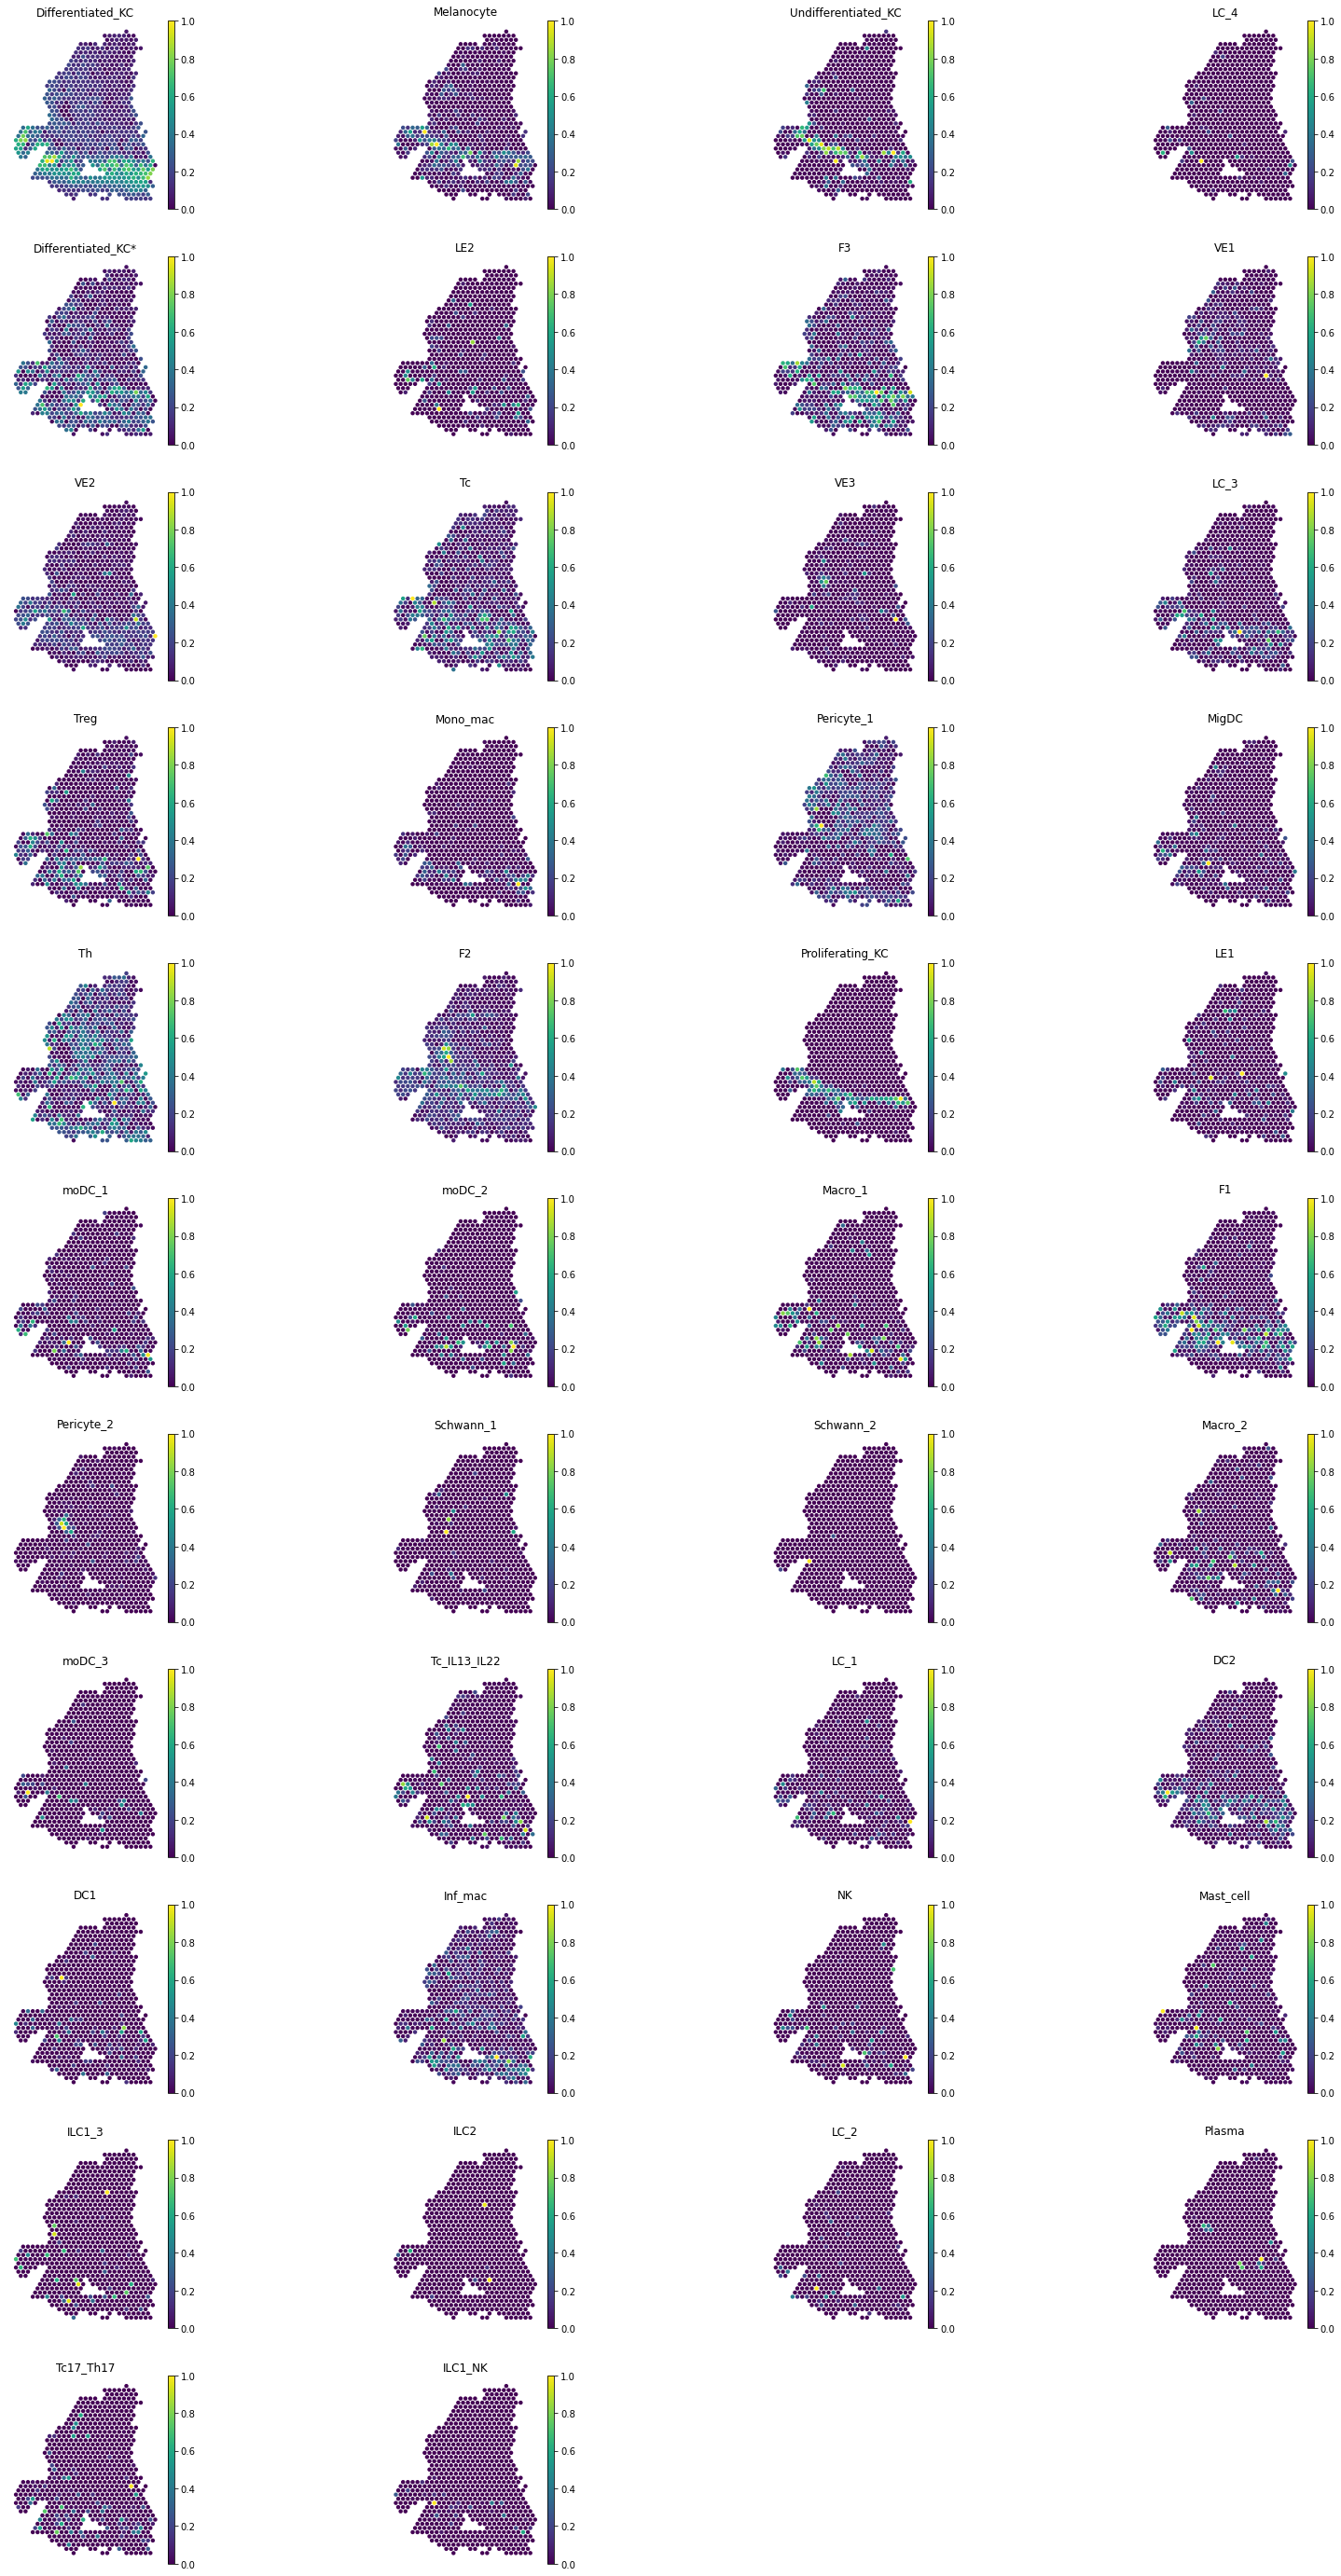

In [27]:
tg.plot_cell_annotation_sc(ad_sp_il17a, annotation_list, x='x', y='y', spot_size= 500, perc=0.00)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sampleP15509_1004__celltype_annotations.pdf'))
# plt.close()

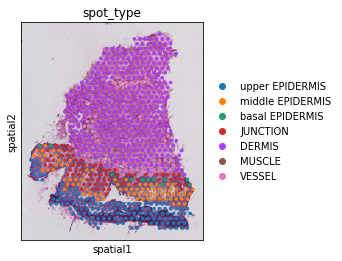

In [28]:
# figure in publication 
sc.pl.spatial(ad_sp_s4, color='spot_type', library_id='P15509_1004')

## Scores

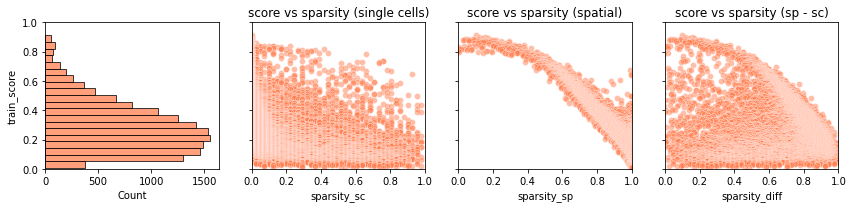

In [72]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

In [73]:
ad_map.uns['train_genes_df']

train_score  sparsity_sc  sparsity_sp  sparsity_diff
eef1a1      0.910754     0.000000     0.101064       0.101064
b2m         0.899132     0.000000     0.118351       0.118351
rps12       0.897309     0.000000     0.155585       0.155585
mt-co1      0.896034     0.000000     0.121011       0.121011
actb        0.895994     0.000000     0.136968       0.136968
...              ...          ...          ...            ...
tmem262     0.014311     0.292683     0.998670       0.705987
pcdh17      0.013897     0.536585     0.998670       0.462085
cfap57      0.013423     0.585366     0.994681       0.409315
wfdc2       0.011387     0.414634     0.998670       0.584036
abca13      0.006634     0.756098     0.998670       0.242573

[14664 rows x 4 columns]

## New spatial data via aligned single cells

In [74]:
# Faster mapping
ad_map_cells = tg.map_cells_to_space(
    adata_sc=ad_sc_pso, adata_sp=ad_sp_s4,
    num_epochs=500, mode='cells', cluster_label='subclass_label', 
    density_prior='rna_count_based', device='cpu')
# RuntimeError: CUDA out of memory. Tried to allocate 64.24 GiB (GPU 0; 39.59 GiB total capacity; 
# 26.71 GiB already allocated; 12.07 GiB free; 26.71 GiB reserved in total by PyTorch)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 14664 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.239, KL reg: 0.120
Score: 0.456, KL reg: 0.001
Score: 0.476, KL reg: 0.000
Score: 0.479, KL reg: 0.000
Score: 0.481, KL reg: 0.000


INFO:root:Saving results..


In [ ]:
ad_map_cells.obs

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


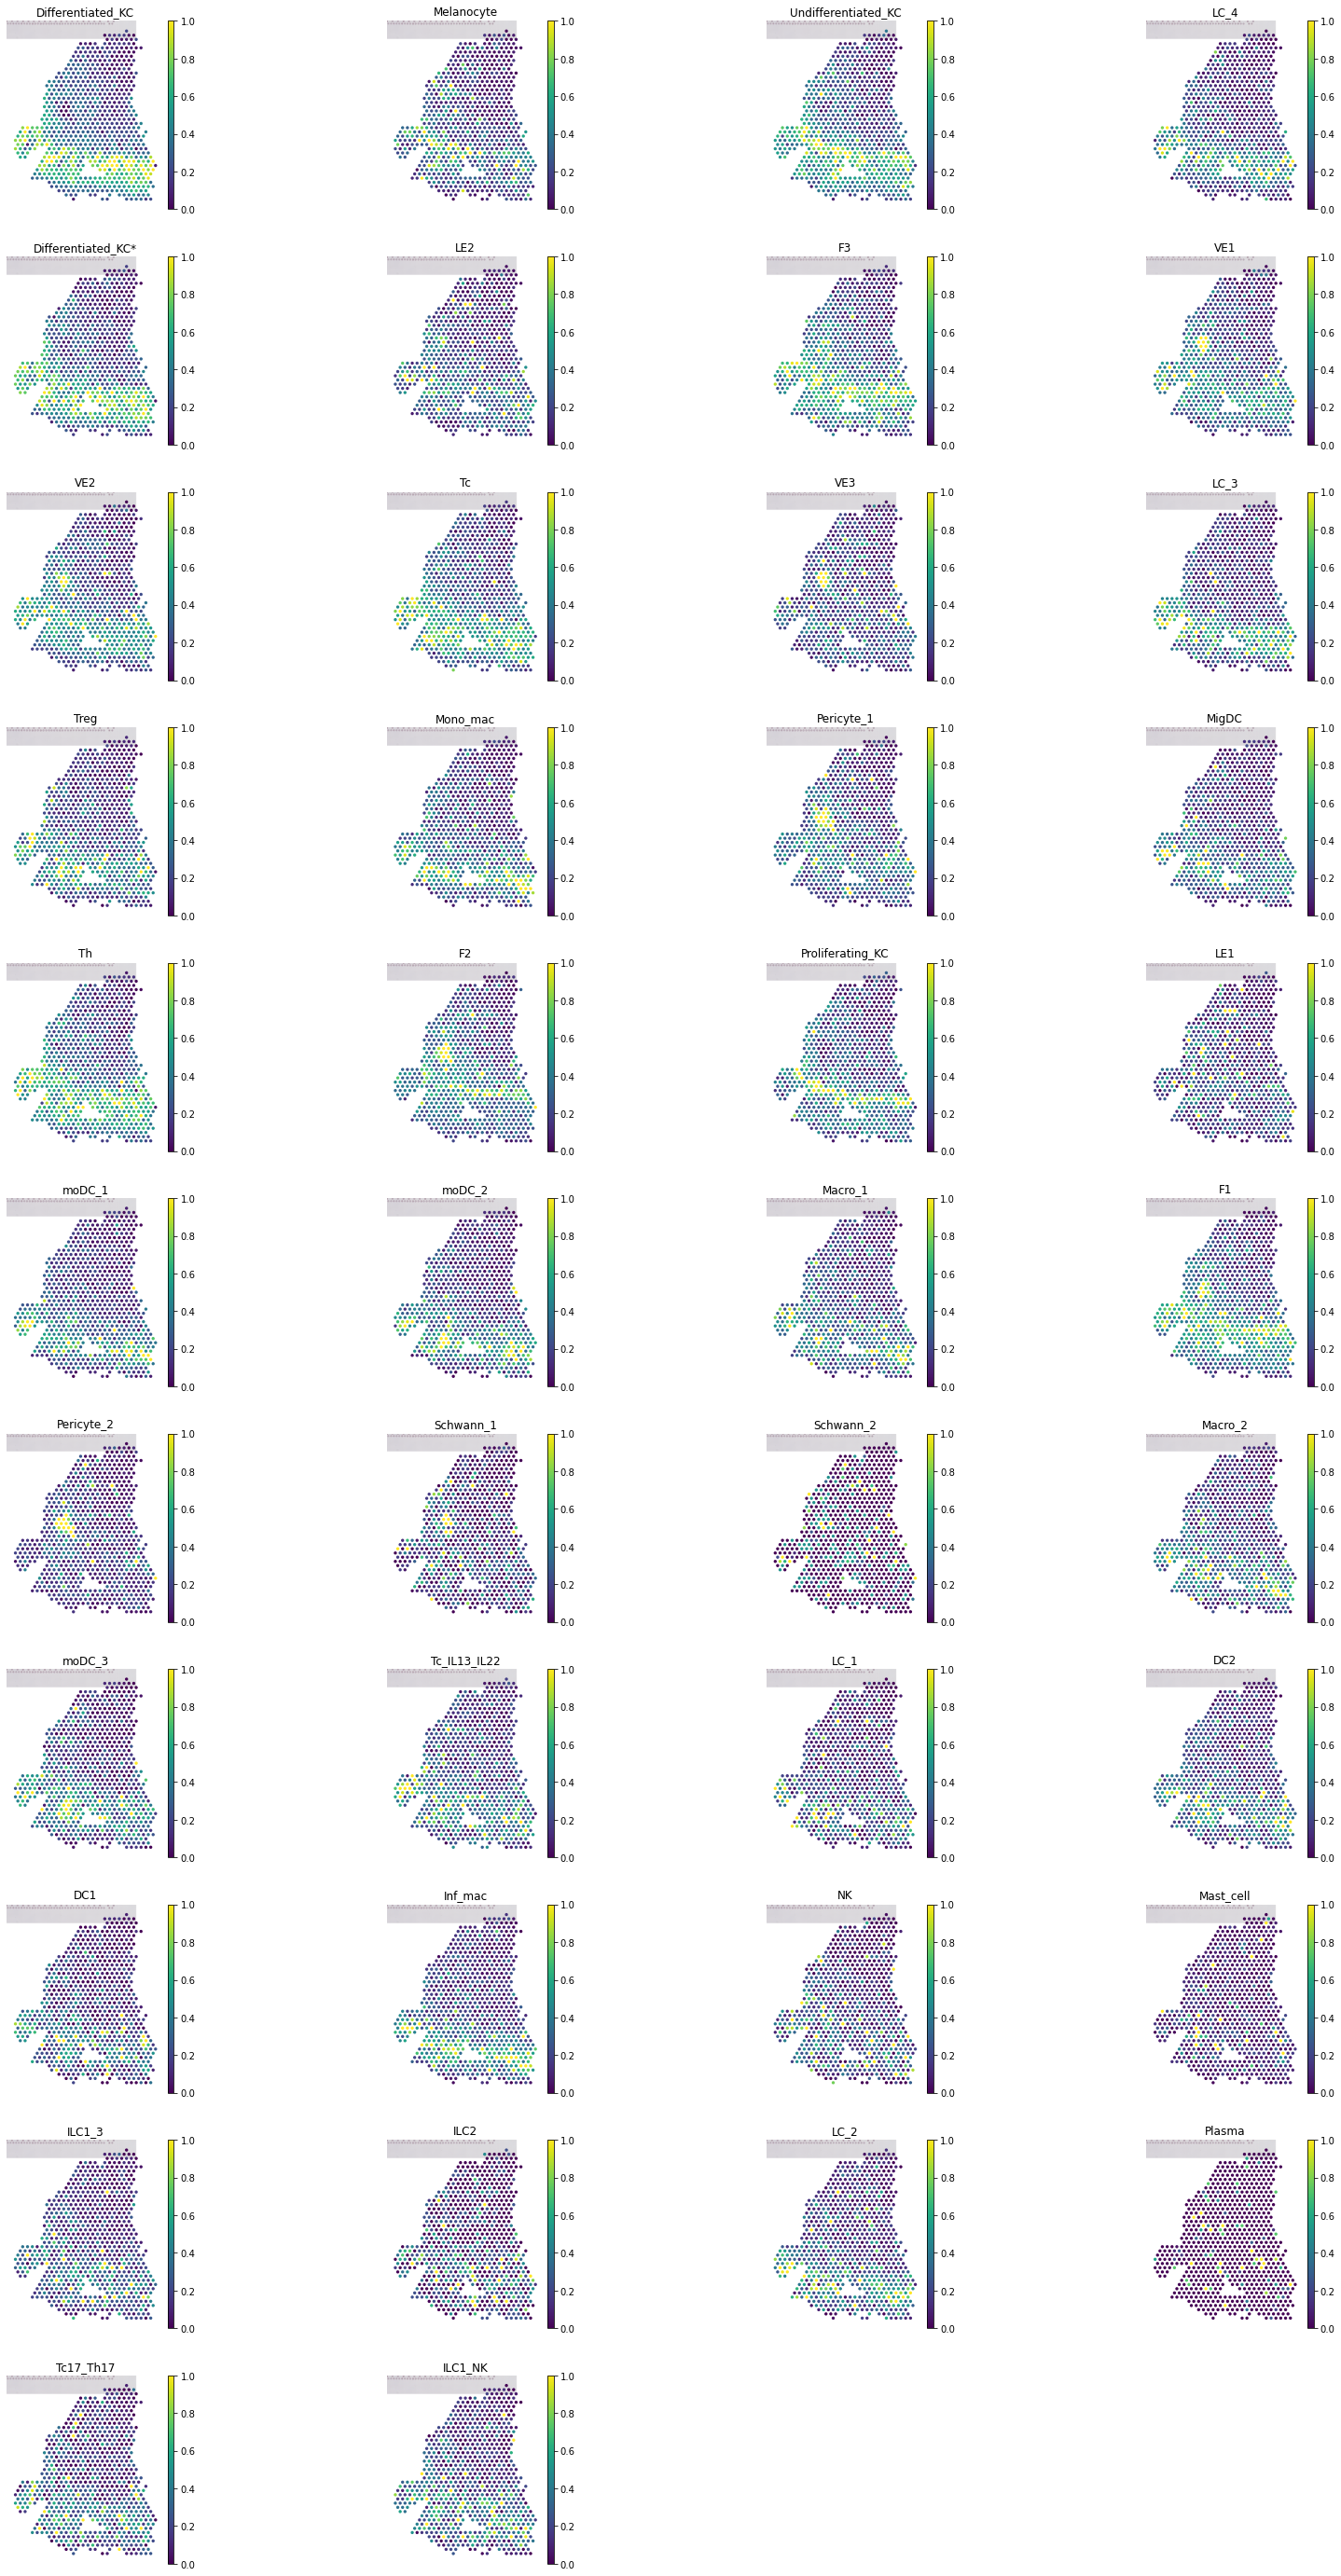

In [41]:
tg.project_cell_annotations(ad_map_cells, ad_sp, annotation="subclass_label")
annotation_list_cells = list(pd.unique(ad_sc.obs['subclass_label']))
tg.plot_cell_annotation_sc(ad_sp, annotation_list_cells, perc=0.02)

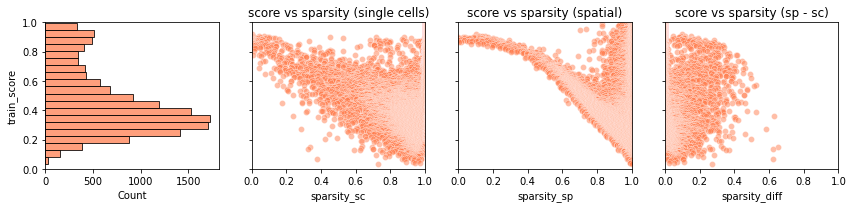

In [42]:
tg.plot_training_scores(ad_map_cells, bins=20, alpha=.5)

If the __mapping mode__ is **'cells'**, we can now generate the "new spatial data" using the mapped single cell: this is done via `project_genes`. The function accepts as input a mapping (adata_map) and corresponding single cell data (adata_sc). The result is a voxel-by-gene AnnData, formally similar to adata_st, but containing gene expression from the mapped single cell data rather than Visium. For downstream analysis, we always replace adata_st with the corresponding `ad_ge`.

In [43]:
# Project gene expression data to space
ad_ge = tg.project_genes(adata_map=ad_map_cells, adata_sc=ad_sc)

In [ ]:
tg.plot_genes_sc(['il17a', 'ifng', 'il13'], adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, 
                 perc = 0.001, return_figure=False)

In [51]:
ad_map_cells.uns['train_genes_df']

train_score  sparsity_sc  sparsity_sp  sparsity_diff
klk12        0.994711     0.999958     0.989446      -0.010512
cxxc4        0.993884     0.999809     0.997361      -0.002448
cplx3        0.993594     0.999951     0.982850      -0.017101
rptn         0.993270     0.999949     0.988127      -0.011822
zic2         0.992352     0.999709     0.994723      -0.004986
...               ...          ...          ...            ...
ly9          0.050000     0.930102     0.998681       0.068578
medag        0.047159     0.887322     0.997361       0.110040
clec2a       0.039368     0.939625     0.990765       0.051140
pparg        0.037029     0.969184     0.990765       0.021582
hla-drb5     0.034454     0.728066     0.998681       0.270614

[14463 rows x 4 columns]

In [52]:
# Inspect genes mapping involved in training
# Choose a few training genes mapped with low score, to try to understand why.
genes = ['clec2a', 'pparg', 'hla-drb5']

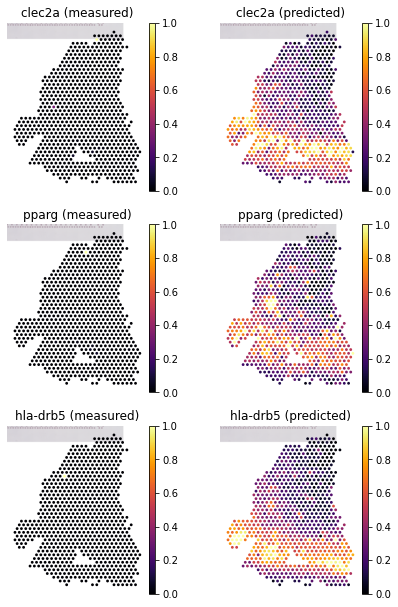

In [53]:
tg.plot_genes_sc(genes, adata_measured=ad_sp_s4, adata_predicted=ad_ge, perc=0.02)

## Inspecting the test transcriptome is an essential to validate mapping.
This below figure is the most important validation plot in Tangram. Each dot represents a gene; the x-axis indicates the score, and the y-axis the sparsity of that gene in the spatial data. Unsurprisingly, the genes predicted with low score represents very sparse genes in the spatial data, suggesting that the Tangram predictions correct expression in those genes. Note that curve observed above is typical of Tangram mappings: the area under that curve is the most reliable metric we use to evaluate mapping.

In [55]:
# df_all_genes = tg.compare_spatial_geneexp(ad_ge, ad_sp_s4, ad_sc)
# tg.plot_auc(df_all_genes)

TypeError: expected non-empty vector for x

- Inspect predictions

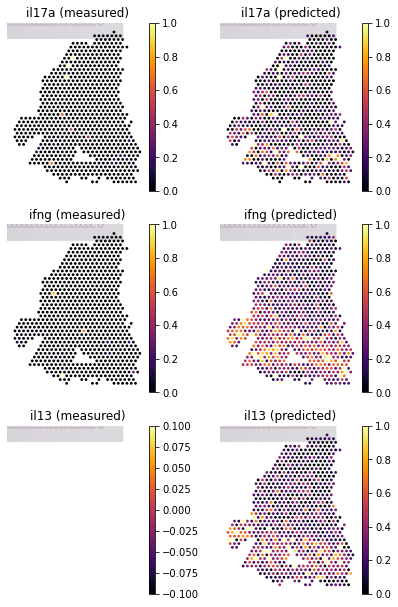

In [56]:
tg.plot_genes_sc(['il17a', 'ifng', 'il13'], adata_measured=ad_sp_s4, adata_predicted=ad_ge, perc=0.02)